In [25]:
from dotenv import load_dotenv
from langchain.globals import set_debug
from langchain.chat_models import ChatOpenAI
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor
from langchain.agents import tool
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from langchain.tools.render import format_tool_to_openai_function

import tempfile
import os

set_debug(True)
load_dotenv()

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")

assistant_instruction = r'You a helpful GIS assistant. Save all data obtained from APIs into a temporary file.'
model_name = f'gpt-4-1106-preview'
DRAMMEN_OGC_API_URL = 'https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005'
user_input = f'Plot the contents on this API endpoint: {DRAMMEN_OGC_API_URL}.'

In [26]:
def save_to_temp_file(content: str, file_name: str = None) -> str:
    """
    Saves content to a file in the Linux temporary folder.

    Parameters:
    content (str): The content to be saved in the file.
    file_name (str, optional): The name of the file. If not provided, a random name is generated.

    Returns:
    str: The path to the saved file.
    """
    if file_name:
        temp_file_path = os.path.join(tempfile.gettempdir(), file_name)
    else:
        temp_file = tempfile.NamedTemporaryFile(delete=False)
        temp_file_path = temp_file.name
        temp_file.close()

    with open(temp_file_path, 'w') as file:
        file.write(content)

    return temp_file_path

@tool
def make_http_request(url: str, save_file_name: str) -> str:
    """
    Performs an HTTP GET request to the specified URL and saves text content of the response to a temporary file.

    Parameters:
    url (str): URL to which the GET request is made.
    save_file_name (str): Name of the temporary file where the response content is saved.

    Returns:
    str: A preview (the first 1000 characters) of the content of the response if successful, or an error message with the status code
         if the request fails.

    Exceptions:
    Raises a requests.RequestException for issues like connection errors or timeouts.
    """
    try:
        response = requests.get(url)
        if response.status_code == 200:
            save_to_temp_file(response.text, save_file_name)
            return response.text[:1000]  
        else:
            return f"Request failed with status code: {response.status_code}"
    except requests.RequestException as e:
        return f"An error occurred: {e}"

@tool
def plot_geojson(geojson_path: str):
    """
    Plots a GeoJSON file.

    Parameters:
    geojson_path (str): The path to the temporary GeoJSON file.
    """
    try: 
        temp_file_path = os.path.join(tempfile.gettempdir(), geojson_path)
        gdf = gpd.read_file(temp_file_path)
        gdf.plot()
        plt.show()
        return 'File plotted successfully'
    except requests.RequestException as e:
        return f"An error occurred: {e}"

tools = [make_http_request, plot_geojson]

llm_with_tools = llm.bind(functions=[format_tool_to_openai_function(t) for t in tools])

In [27]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIFunctionsAgentOutputParser()
)

[chain/start] [1:chain:AgentExecutor] Entering Chain run with input:
{
  "input": "Plot the contents on this API endpoint: https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005."
}
[chain/start] [1:chain:AgentExecutor > 2:chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Plot the contents on this API endpoint: https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005.",
  "intermediate_steps": []
}
[chain/start] [1:chain:AgentExecutor > 2:chain:RunnableSequence > 3:chain:RunnableParallel] Entering Chain run with input:
{
  "input": "Plot the contents on this API endpoint: https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005.",
  "intermediate_steps": []
}
[chain/start] [1:chain:AgentExecutor > 2:chain:RunnableSequence > 3:chain:RunnableParallel > 4:chain:<lambda>] Entering Chain run with input:
{
  "input": "Plot the contents on this API endpoint

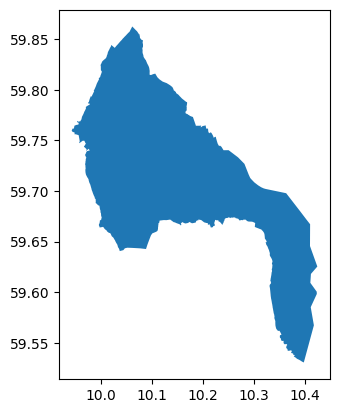

[tool/end] [1:chain:AgentExecutor > 17:tool:plot_geojson] s] Exiting Tool run with output:
"File plotted successfully"
[chain/start] [1:chain:AgentExecutor > 18:chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:AgentExecutor > 18:chain:RunnableSequence > 19:chain:RunnableParallel] Entering Chain run with input:
[inputs]
[chain/start] [1:chain:AgentExecutor > 18:chain:RunnableSequence > 19:chain:RunnableParallel > 20:chain:<lambda>] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:AgentExecutor > 18:chain:RunnableSequence > 19:chain:RunnableParallel > 20:chain:<lambda>] s] Exiting Chain run with output:
{
  "output": "Plot the contents on this API endpoint: https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005."
}
[chain/start] [1:chain:AgentExecutor > 18:chain:RunnableSequence > 19:chain:RunnableParallel > 21:chain:<lambda>] Entering Chain run with input:
[inputs]
[chain/end] [1:chain:AgentExecut

{'input': 'Plot the contents on this API endpoint: https://alenos-tester001.azurewebsites.net/collections/kommuner/items?f=json&kommunenummer=3005.',
 'output': 'The contents of the API endpoint have been plotted successfully.'}

In [28]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

agent_executor.invoke(
    {
        "input": user_input
    }
)